##### algom/playbooks

# prediction_gap


#### Resources
+ [BigQuery](https://console.cloud.google.com/bigquery?folder=&organizationId=&project=algomosaic-nyc)
+ [Storage](https://console.cloud.google.com/storage/browser/algom-trading/models/?project=algomosaic-nyc)



<br> 

### Requirements


In [1]:
import sys
sys.path.append('/home/jovyan/algom-trading/src')
import configs


<br>

### Get data and initiate model

The recommended approach is to point to a SQL file (i.e. `file`). This approach ensures the input data are consistent between model training and subsequent prediction processes.


In [2]:
import numpy as np
from data import dataBlob
data = dataBlob("""
select * except(rnk)
from (
    select *,
    rank() over(partition by ticker_time order by etl_time) as rnk
    from `algomosaic-nyc.algom_dev_features.features_BTC_USD_hour_i01_*`
    where _table_suffix = '2017'
    )
where rnk = 1
""")
data.df = data.df.replace([np.inf, -np.inf], np.nan).dropna()
data.df.head()


Downloading: 100%|██████████| 10001/10001 [00:31<00:00, 320.17rows/s]


,partition_date,etl_time,ticker_time,ticker,exchange,interval,ticker_time_sec,close,high,low,...,RATIO_close_5_close_10,RATIO_close_5_close_15,RATIO_close_5_close_30,RATIO_close_10_close_15,RATIO_close_10_close_30,RATIO_close_10_close_60,RATIO_close_10_close_90,RATIO_close_15_close_30,RATIO_close_15_close_60,RATIO_close_15_close_90
30,2020-04-03,2020-04-03 11:44:58.593547+00:00,2016-11-11 14:00:00+00:00,BTC-USD,CCCAGG,hour,1478872800,717.56,718.17,715.84,...,0.996166,0.999734,1.015028,1.003581,1.018934,1.023762,1.009087,1.015298,1.020108,1.005486
31,2020-04-03,2020-04-03 11:44:58.593547+00:00,2016-11-11 15:00:00+00:00,BTC-USD,CCCAGG,hour,1478876400,716.41,719.39,715.36,...,0.993506,0.997691,1.012024,1.004212,1.018639,1.020682,1.008134,1.014366,1.016400,1.003906
32,2020-04-03,2020-04-03 11:44:58.593547+00:00,2016-11-11 16:00:00+00:00,BTC-USD,CCCAGG,hour,1478880000,715.24,717.00,713.28,...,0.995995,1.001319,1.010347,1.005345,1.014409,1.018851,1.007790,1.009016,1.013435,1.002433
33,2020-04-03,2020-04-03 11:44:58.593547+00:00,2016-11-11 17:00:00+00:00,BTC-USD,CCCAGG,hour,1478883600,715.62,716.87,714.67,...,1.000098,1.007473,1.015520,1.007374,1.015420,1.016243,1.004923,1.007987,1.008804,0.997567
34,2020-04-03,2020-04-03 11:44:58.593547+00:00,2016-11-11 18:00:00+00:00,BTC-USD,CCCAGG,hour,1478887200,716.67,717.58,715.34,...,1.002188,1.001794,1.013400,0.999608,1.011188,1.015103,1.005074,1.011585,1.015502,1.005469


<br>

### Train model

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# reg = RandomForestRegressor()

from model_regression import modelRegression
model = modelRegression(
    data, 
    outcome='ROR_n10', 
    index_features=configs.index_features, 
    omit_features=configs.omit_features,
    to_bq=True
)

from sklearn import ensemble
reg = ensemble.GradientBoostingRegressor(
    loss='ls', 
    learning_rate=0.1,
    n_estimators=500,
    subsample=.9,
    criterion='friedman_mse', 
    min_samples_split= 2,
    min_samples_leaf= 10,
    min_weight_fraction_leaf=0.0, 
    max_depth=8,
    min_impurity_decrease=0.0, 
    min_impurity_split=None, 
    init=None,
    random_state=None, 
    max_features=None, 
    alpha=0.9, 
    verbose=0,
    max_leaf_nodes=None, 
    warm_start=False, 
    validation_fraction=0.1, 
    n_iter_no_change=None, 
    tol=0.0001
)

model.train(reg)


In [ ]:
"""
MODEL PERFORMANCE SUMMARY
500 estimators
        - Mean Absolute Error:	 0.00472
        - Mean Absolute Outcome:	 0.00874
        - Mean Absolute Percent Error:	 0.53944
        - Error Variance:	 6e-05
        - R-Squared:		 0.74024


MODEL PERFORMANCE SUMMARY
100 estimators
        - Mean Absolute Error:	 0.00539
        - Mean Absolute Outcome:	 0.00874
        - Mean Absolute Percent Error:	 0.61671
        - Error Variance:	 7e-05
        - R-Squared:		 0.67531

"""

In [5]:
print('model_id: ' + model.model_id)
print('model_execution_id: ' + model.model_execution_id)
model.save()

model_id: ed33cccccb394dec2561ae22dd9225a01f150129
model_execution_id: dd0003cdee0380354f29e857bebf4258e5a48f4c
Dumped model to:
	/home/jovyan/algom-trading/models/20200410_GradientBoostingRegressor_BTC-USD_dd0003cdee0380354f29e857bebf4258e5a48f4c.pickle
Uploaded pickle to Google Storage:
	https://storage.googleapis.com/algom-dev/models/20200410_GradientBoostingRegressor_BTC-USD_dd0003cdee0380354f29e857bebf4258e5a48f4c.pickle
RUNNING: loading algomosaic-nyc:algom_dev_storage.model_storage_20200410 into BigQuery.


1it [00:02,  2.69s/it]

Uploaded storage metadata to Google BigQuery:
	algom_dev_storage.model_storage_YYYYMMDD
Saved model to Google Storage:
	models/20200410_GradientBoostingRegressor_BTC-USD_dd0003cdee0380354f29e857bebf4258e5a48f4c.pickle


<br><br>

### OOS validation

Get performance of future dates


In [2]:
from data import dataBlob
import numpy as np
data_2020 = dataBlob("""
select * except(rnk)
from (
    select *,
    rank() over(partition by ticker_time order by etl_time) as rnk
    from `algomosaic-nyc.algom_dev_features.features_BTC_USD_hour_i01_*`
    where _table_suffix = '2018'
    and extract(month from ticker_time) = 1
    )
where rnk = 1
""")
data_2020.df = data_2020.df.replace([np.inf, -np.inf], np.nan).dropna()
data_2020.df.head()


Downloading: 100%|██████████| 745/745 [00:02<00:00, 275.58rows/s]


,partition_date,etl_time,ticker_time,ticker,exchange,interval,ticker_time_sec,close,high,low,...,RATIO_close_5_close_10,RATIO_close_5_close_15,RATIO_close_5_close_30,RATIO_close_10_close_15,RATIO_close_10_close_30,RATIO_close_10_close_60,RATIO_close_10_close_90,RATIO_close_15_close_30,RATIO_close_15_close_60,RATIO_close_15_close_90
0,2020-04-03,2020-04-03 11:46:31.224056+00:00,2018-01-01 00:00:00+00:00,BTC-USD,CCCAGG,hour,1514764800,13642.93,13857.01,13598.91,...,0.997531,1.021122,1.016482,1.023649,1.018998,0.928883,0.918084,0.995456,0.907423,0.896873
1,2020-04-03,2020-04-03 11:46:31.224056+00:00,2018-01-01 01:00:00+00:00,BTC-USD,CCCAGG,hour,1514768400,13352.04,13690.14,13330.07,...,1.041838,1.058999,1.032590,1.016472,0.991124,0.889213,0.886451,0.975062,0.874803,0.872086
2,2020-04-03,2020-04-03 11:46:31.224056+00:00,2018-01-01 02:00:00+00:00,BTC-USD,CCCAGG,hour,1514772000,13408.70,13488.90,13318.52,...,1.033272,1.043675,1.016832,1.010068,0.984090,0.887708,0.889086,0.974280,0.878859,0.880224
3,2020-04-03,2020-04-03 11:46:31.224056+00:00,2018-01-01 03:00:00+00:00,BTC-USD,CCCAGG,hour,1514775600,13458.77,13647.63,13383.99,...,1.031725,1.023613,0.995031,0.992137,0.964434,0.866078,0.875701,0.972077,0.872942,0.882641
4,2020-04-03,2020-04-03 11:46:31.224056+00:00,2018-01-01 04:00:00+00:00,BTC-USD,CCCAGG,hour,1514779200,13631.46,13633.43,13364.42,...,1.028663,1.023841,0.996197,0.995312,0.968439,0.876447,0.880433,0.973000,0.880575,0.884580


In [3]:
from model_regression import modelRegression
model_2020 = modelRegression(
    data_2020,
    #model_execution_id='616fa5b867f3dc740786fa378f32c34a1bf3dd29',
    #model_execution_id='0cce0397b07f1d534ed4bd6f2f7d6dac8c12a04d',
    #model_execution_id='598523976aeb4509b97e4fac113a7b65e1d43b4d',
    #model_execution_id='ae3b21a51c1bf31936dc9ab9f3596a5ab4f20aba',
    model_execution_id='dd0003cdee0380354f29e857bebf4258e5a48f4c',
    outcome='ROR_n10', 
    index_features=configs.index_features, 
    omit_features=configs.omit_features,
    to_bq=False
)


Initialized model. As a next step, run self.predict() or self.train().


In [4]:
model_2020.predict()


The following paths have been added to self.storage:
            - model_storage_filepath: models/20200410_GradientBoostingRegressor_BTC-USD_dd0003cdee0380354f29e857bebf4258e5a48f4c.pickle
            - model_filename:	20200410_GradientBoostingRegressor_BTC-USD_dd0003cdee0380354f29e857bebf4258e5a48f4c.pickle
            - model_storage_id:	20200410_GradientBoostingRegressor_BTC-USD_dd0003cdee0380354f29e857bebf4258e5a48f4c
            - model_execution_id:	dd0003cdee0380354f29e857bebf4258e5a48f4c
            
Downloaded file from GCS to: /home/jovyan/algom-trading/models/20200410_GradientBoostingRegressor_BTC-USD_dd0003cdee0380354f29e857bebf4258e5a48f4c.pickle
Model metadata added to `self.metadata.metadata`
Model metadata added to `self.metadata.parameters`
Get model performance.
Set R^2 to `self.rsquared`
The following performance measures have been added:
                - self.mean_abs_error
                - self.mean_abs_outcome
                - self.mean_abs_pct_error
          

In [8]:
# model_2020.features.head()
# model_2020.feature_list
# model.feature_list

model_2020.plots.plot_predictions_scatterplot()


NameError: name 'DATE' is not defined

<br>

## View performance 

+ Trending predictions vs outcomes
+ Histogram of predictions vs outcomes


PLOT: Predictions by Date
        `self.plot_predictions_by_date(start_date, end_date)`
        
PLOT: Prediction Errors by Date`
PLOT: Predictions Histogram
PLOT: Predictions Histogram
PLOT: Predictions by Date


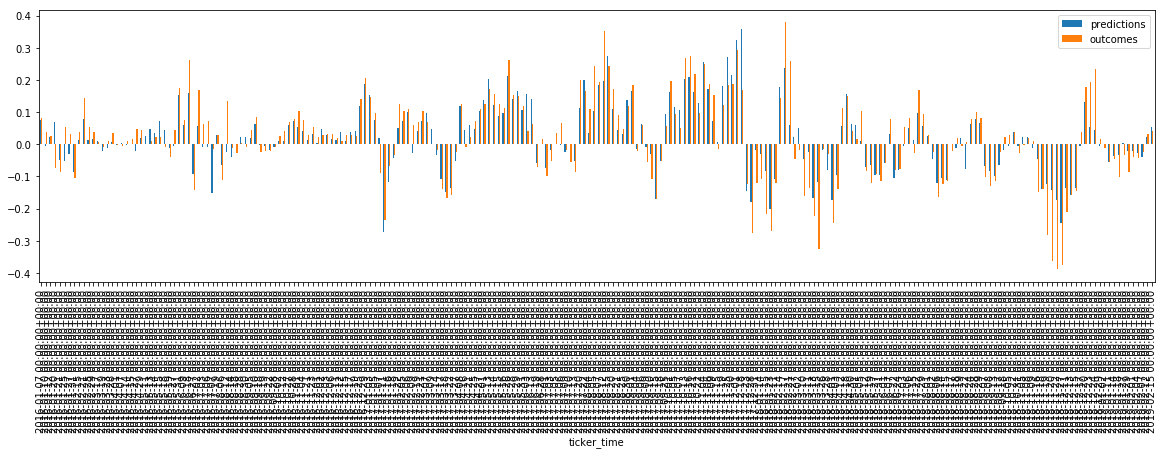

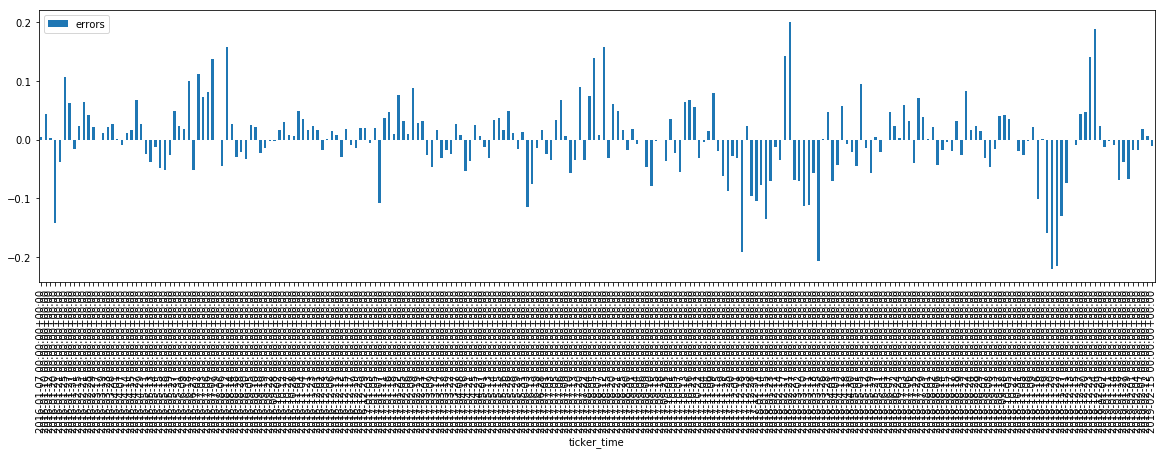

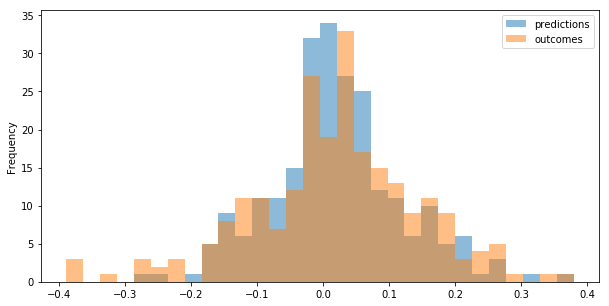

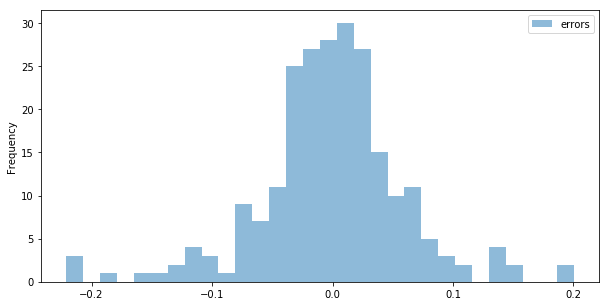

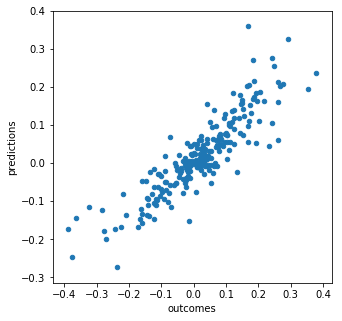

In [12]:
start_date='2016-01-01'
end_date='2020-01-01'
%matplotlib inline

model.plot_predictions_by_date(start_date, end_date)
model.plot_errors_by_date(start_date, end_date)
model.plot_predictions_histogram(start_date, end_date)
model.plot_errors_histogram(start_date, end_date)
model.plot_predictions_scatterplot(start_date, end_date)


In [15]:
features = model.feature_importance.feature_importance
features[0:10]


,model_execution_id,data_id,outcome_variable,variable,importance,rank,pct_rank
0,1d46caededda136ed19b14cb29c541187ed930eb,bcb15a1bd7b5e13e44bd55b605a990bb39ebe767,ROR_n10,RATIO_LOG_MIN_10_MIN_10,0.04522,1.0,1.000000
1,1d46caededda136ed19b14cb29c541187ed930eb,bcb15a1bd7b5e13e44bd55b605a990bb39ebe767,ROR_n10,RATIO_LOG_MIN_10_MIN_20,0.03611,2.0,0.996622
2,1d46caededda136ed19b14cb29c541187ed930eb,bcb15a1bd7b5e13e44bd55b605a990bb39ebe767,ROR_n10,AROR_8,0.03522,3.0,0.993243
3,1d46caededda136ed19b14cb29c541187ed930eb,bcb15a1bd7b5e13e44bd55b605a990bb39ebe767,ROR_n10,MAX_3,0.03461,4.0,0.989865
4,1d46caededda136ed19b14cb29c541187ed930eb,bcb15a1bd7b5e13e44bd55b605a990bb39ebe767,ROR_n10,Bollinger_pct_b_140,0.02692,5.0,0.986486
5,1d46caededda136ed19b14cb29c541187ed930eb,bcb15a1bd7b5e13e44bd55b605a990bb39ebe767,ROR_n10,DIFF_AROR_1_AROR_20,0.02255,6.0,0.983108
6,1d46caededda136ed19b14cb29c541187ed930eb,bcb15a1bd7b5e13e44bd55b605a990bb39ebe767,ROR_n10,RATIO_LOG_MAX_10_MAX_40,0.02189,7.0,0.979730
7,1d46caededda136ed19b14cb29c541187ed930eb,bcb15a1bd7b5e13e44bd55b605a990bb39ebe767,ROR_n10,SO_EMA_nK50_nS1,0.02166,8.0,0.976351
8,1d46caededda136ed19b14cb29c541187ed930eb,bcb15a1bd7b5e13e44bd55b605a990bb39ebe767,ROR_n10,DIFF_AROR_3_AROR_50,0.02023,9.0,0.972973
9,1d46caededda136ed19b14cb29c541187ed930eb,bcb15a1bd7b5e13e44bd55b605a990bb39ebe767,ROR_n10,RATIO_LOG_MIN_10_MAX_10,0.01792,10.0,0.969595


In [16]:
features[len(features)-10:len(features)]

,model_execution_id,data_id,outcome_variable,variable,importance,rank,pct_rank
286,1d46caededda136ed19b14cb29c541187ed930eb,bcb15a1bd7b5e13e44bd55b605a990bb39ebe767,ROR_n10,MIN_3,0.00004,286.0,0.037162
287,1d46caededda136ed19b14cb29c541187ed930eb,bcb15a1bd7b5e13e44bd55b605a990bb39ebe767,ROR_n10,RATIO_close_close_10,0.00004,286.0,0.037162
288,1d46caededda136ed19b14cb29c541187ed930eb,bcb15a1bd7b5e13e44bd55b605a990bb39ebe767,ROR_n10,MIN_100,0.00003,289.0,0.027027
289,1d46caededda136ed19b14cb29c541187ed930eb,bcb15a1bd7b5e13e44bd55b605a990bb39ebe767,ROR_n10,AROR_150,0.00002,290.0,0.023649
290,1d46caededda136ed19b14cb29c541187ed930eb,bcb15a1bd7b5e13e44bd55b605a990bb39ebe767,ROR_n10,EMA_10,0.00001,292.0,0.016892
291,1d46caededda136ed19b14cb29c541187ed930eb,bcb15a1bd7b5e13e44bd55b605a990bb39ebe767,ROR_n10,EMA_150,0.00001,292.0,0.016892
292,1d46caededda136ed19b14cb29c541187ed930eb,bcb15a1bd7b5e13e44bd55b605a990bb39ebe767,ROR_n10,EMA_30,0.00001,292.0,0.016892
293,1d46caededda136ed19b14cb29c541187ed930eb,bcb15a1bd7b5e13e44bd55b605a990bb39ebe767,ROR_n10,EMA_50,0.00000,295.0,0.006757
294,1d46caededda136ed19b14cb29c541187ed930eb,bcb15a1bd7b5e13e44bd55b605a990bb39ebe767,ROR_n10,RATIO_LOG_EMA_5_EMA_20,0.00000,295.0,0.006757
295,1d46caededda136ed19b14cb29c541187ed930eb,bcb15a1bd7b5e13e44bd55b605a990bb39ebe767,ROR_n10,RATIO_LOG_MAX_20_MAX_200,0.00000,295.0,0.006757


<br>

### View trending features


In [20]:
start_date = '2016-01-01'
end_date = '2017-01-01'
%matplotlib inline 

from data_mgmt import data_mgmt as dm

dm.plot_features(df = model.df, x = 'ticker_time', y = 'ROR_n10',
    start_date=start_date, end_date=end_date)

dm.plot_features(df = model.df, x = 'ticker_time', y = 'ATR_7',
    start_date=start_date, end_date=end_date, chart_type = 'line')

dm.plot_features(df = model.df, x = 'ticker_time', y = 'EMA_20',
    start_date=start_date, end_date=end_date, chart_type='line')

